In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder as OHE, MinMaxScaler
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer, precision_recall_curve, accuracy_score, roc_curve, recall_score, precision_score, f1_score

# Import dataset
Let's check first lines of dataset to get some basic image how the data looks

In [2]:
df = pd.read_csv('churn_data_sample.csv',sep=';')
df #just to see columns and get basic idea how the data looks

,gender,is_senior,has_partner,has_dependents,months_customer,has_phone_service,has_multiple_lines,has_internet,has_online_security,uses_online_backup,uses_device_protection,uses_tech_support,uses_streaming_tv,uses_streaming_movies,contract_type,electronic_billing,payment_method,monthly_fees,total_fees,churned
0,Female,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,24.80,24.8,Yes
1,Male,0,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45,No
2,Female,0,Yes,Yes,52,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,1031.7,No
3,Female,0,No,No,1,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Electronic check,76.35,76.35,Yes
4,Male,0,No,No,67,Yes,No,DSL,No,No,No,Yes,No,No,Two year,No,Bank transfer (automatic),50.55,3260.1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6841,Male,1,Yes,No,44,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,One year,No,Mailed check,88.40,3912.9,Yes
6842,Male,0,Yes,Yes,27,No,No phone service,DSL,No,Yes,Yes,No,No,Yes,One year,Yes,Credit card (automatic),45.85,1246.4,No
6843,Male,0,No,No,31,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Electronic check,103.45,3066.45,Yes
6844,Male,0,No,No,13,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.75,265.75,No


# Show distribution of column `months_customer`
So that we can check whether there are some patterns

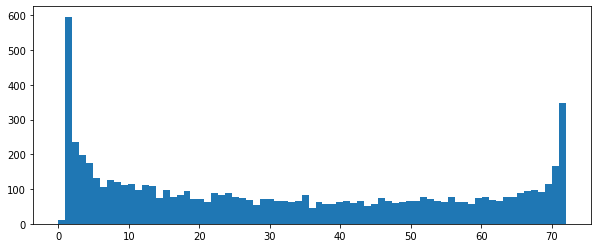

In [3]:
plt.figure(figsize=(10,4))
_ = plt.hist(df['months_customer'],bins=len(df['months_customer'].unique()))
plt.show()

## How looks the distribution of “months customer” (number of months under contract) of a customer?

Most customers have spent one month with the company so far. The second largest group are customers who spent 72 months with the company. From the distribution, it seems like there are either new customers, or very loyal customers, who are with the company for very long time.

As 6 years (72 months) is maximum value, and this group is quite common, it is possible that it actually includes also some older data, that just got value 72.

# Calculate the average revenue per user by contract type and by months under contract.
__For the latter, choose an appropriate bin, as months under contract is a “continuous” variable. Which bin would make business sense, in your experience?__

Binning of months under contract: From the chart above, I would not use simple binning based on fixed range, but I would select something that makes more sense from product / business point of view. I see following groups in the data:
- Very new customers: 0 or 1 month under contract. There are lot of these customers; this means, that company gained an exceptional number of new customers last month, or that lot of new customers usually leaves after few months: however, to be able to confirm this, we would need to see this chart in time, or with former customers (like history snapshot; when the customer joined, when he/she left)
- Partially new customers: 2 to 6 months. Customers who joined recently, but still are not considered as loyal, or long-term customers
- half year to 2 years customers: More _stable_ customers, not recent
- more than 2 years, less than 6 years: loyal customers, but not exteremely old.
- 6 years and more: very loyal customers

In [4]:
df['months_customer_binned'] = pd.cut(df['months_customer'], [0,1,6,24,71,72])
df['total_fees'] = df['total_fees'].apply(lambda x: x if x not in {'',' '} else '0.0').astype(float)
df['total_fees_weighted'] = (df['total_fees']/df['months_customer']).fillna(0)

## Average revenue per user by binned months under contract

In [5]:
#showing revenue for months_customer variable
df[['months_customer_binned','total_fees','total_fees_weighted']].groupby('months_customer_binned').agg(np.mean)

,total_fees,total_fees_weighted
months_customer_binned,,
"(0, 1]",50.216946,50.216946
"(1, 6]",210.388298,57.939458
"(6, 24]",894.831228,60.537436
"(24, 71]",3512.588409,69.509137
"(71, 72]",5793.825648,80.469801


## Average revenue per user by contract type

In [6]:
df[['contract_type','total_fees','total_fees_weighted']].groupby('contract_type').agg(np.mean)

,total_fees,total_fees_weighted
contract_type,,
Month-to-month,1360.185658,66.270528
One year,3043.884714,65.160430
Two year,3704.875782,60.466277


In [7]:
df[['contract_type','months_customer']].groupby('contract_type').agg(np.mean)

,months_customer
contract_type,
Month-to-month,17.953956
One year,42.127437
Two year,56.834457


# Can you identify any pattern in the most profitable customers that churned?

This also partially answers __Which variables are the main drivers of churn?__

Let's show how values for most profitable are distributed per individual variables, with categorical variables being shown in pivot table, and continuous variables binned as histograms + ratios of churned / not churned per each bin

gender


churned,No,Yes,No_perc,Yes_perc
gender,,,,
Female,303,36,0.893805,0.106195
Male,298,48,0.861272,0.138728


is_senior


churned,No,Yes,No_perc,Yes_perc
is_senior,,,,
0,473,61,0.885768,0.114232
1,128,23,0.847682,0.152318


has_partner


churned,No,Yes,No_perc,Yes_perc
has_partner,,,,
No,129,27,0.826923,0.173077
Yes,472,57,0.892250,0.107750


has_dependents


churned,No,Yes,No_perc,Yes_perc
has_dependents,,,,
No,387,63,0.860000,0.140000
Yes,214,21,0.910638,0.089362


months_customer


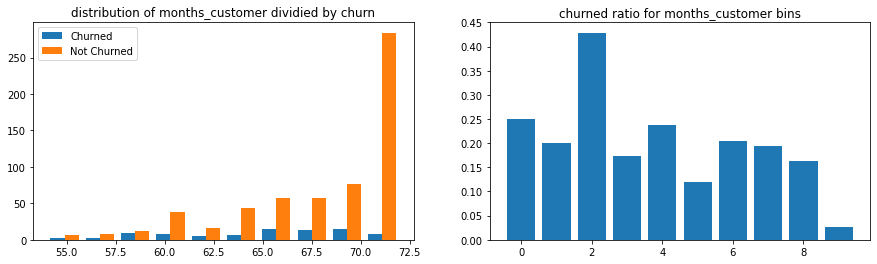

has_phone_service


churned,No,Yes,No_perc,Yes_perc
has_phone_service,,,,
Yes,601,84,0.877372,0.122628


has_multiple_lines


churned,No,Yes,No_perc,Yes_perc
has_multiple_lines,,,,
No,72,8,0.90000,0.10000
Yes,529,76,0.87438,0.12562


has_internet


churned,No,Yes,No_perc,Yes_perc
has_internet,,,,
DSL,95,1,0.989583,0.010417
Fiber optic,506,83,0.859083,0.140917


has_online_security


churned,No,Yes,No_perc,Yes_perc
has_online_security,,,,
No,213,52,0.803774,0.196226
Yes,388,32,0.923810,0.076190


uses_online_backup


churned,No,Yes,No_perc,Yes_perc
uses_online_backup,,,,
No,114,19,0.857143,0.142857
Yes,487,65,0.882246,0.117754


uses_device_protection


churned,No,Yes,No_perc,Yes_perc
uses_device_protection,,,,
No,114,19,0.857143,0.142857
Yes,487,65,0.882246,0.117754


uses_tech_support


churned,No,Yes,No_perc,Yes_perc
uses_tech_support,,,,
No,191,47,0.802521,0.197479
Yes,410,37,0.917226,0.082774


uses_streaming_tv


churned,No,Yes,No_perc,Yes_perc
uses_streaming_tv,,,,
No,68,6,0.918919,0.081081
Yes,533,78,0.872340,0.127660


uses_streaming_movies


churned,No,Yes,No_perc,Yes_perc
uses_streaming_movies,,,,
No,63,5,0.926471,0.073529
Yes,538,79,0.871961,0.128039


contract_type


churned,No,Yes,No_perc,Yes_perc
contract_type,,,,
Month-to-month,54,25,0.683544,0.316456
One year,155,37,0.807292,0.192708
Two year,392,22,0.946860,0.053140


electronic_billing


churned,No,Yes,No_perc,Yes_perc
electronic_billing,,,,
No,161,17,0.904494,0.095506
Yes,440,67,0.867850,0.132150


payment_method


churned,No,Yes,No_perc,Yes_perc
payment_method,,,,
Bank transfer (automatic),206.0,21.0,0.907489,0.092511
Credit card (automatic),217.0,25.0,0.896694,0.103306
Electronic check,150.0,38.0,0.797872,0.202128
Mailed check,28.0,NaN,NaN,NaN


monthly_fees


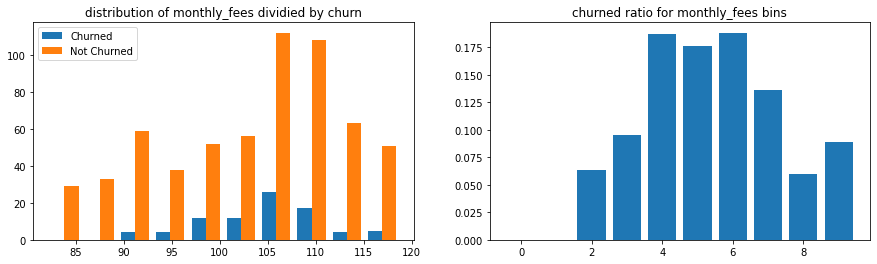

total_fees


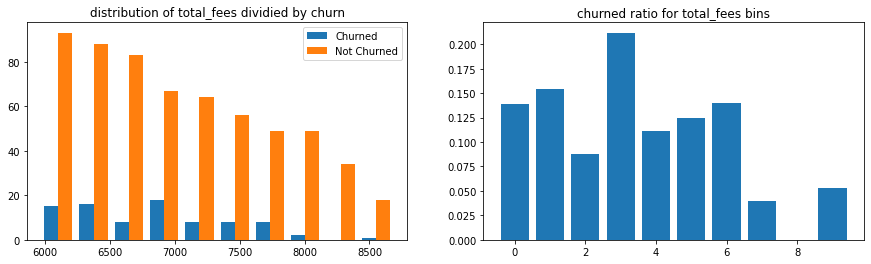

months_customer_binned


churned,No,Yes,No_perc,Yes_perc
months_customer_binned,,,,
"(24, 71]",399,80,0.832985,0.167015
"(71, 72]",202,4,0.980583,0.019417


total_fees_weighted


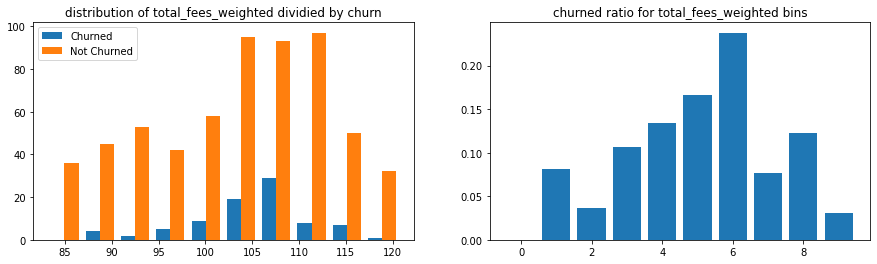

In [8]:
#select most profitable, top 10 percentile, split them into churned / not churned
most_profitable = df[df['total_fees'] >= np.percentile(df['total_fees'],90)]
mp_churned = most_profitable[most_profitable['churned'] == 'Yes']
mp_not_churned = most_profitable[most_profitable['churned'] == 'No']

#show chart / table for each variable (depending on whether the variable is categorical or continous)
for col in most_profitable.columns:
    if col == 'churned':
        continue
    print(col)
    if most_profitable[col].dtype == np.dtype('object') or len(set(most_profitable[col])) < 10:
        pt = pd.pivot_table(most_profitable[[col,'churned']],index=col,columns='churned',aggfunc=len)
        orig_cols = pt.columns.copy()
        for piv_col in pt.columns:
            pt['{}_perc'.format(piv_col)] = pt.apply(axis=1, func=lambda x: x[piv_col]/sum(x[orig_cols]))
        display(pt)
    else:
        fig, [ax1, ax2] = plt.subplots(ncols=2,figsize=(15,4))
        groups, x, _ = ax1.hist([mp_churned[col],mp_not_churned[col]],label=['Churned','Not Churned'])
        percent_per_group = groups[0]/(groups[0]+groups[1])
        ax1.set_title('distribution of {} dividied by churn'.format(col))
        ax2.bar(range(len(percent_per_group)),percent_per_group)
        ax2.set_title('churned ratio for {} bins'.format(col))
        ax1.legend()
        plt.show()

We can see following patterns:
 - people without partner are more likely to churn
 - people who are customers for short time are more likely to churn
 - people who don't have online security, and people who don't use tech support are both more likely to churn
 - people with shorther contract types are much more likely to churn
 - people with electronic check are more likely to churn
 - people with monthly fees between ~100 and ~110 are more likely to churn

# Design and implement a predictive model for customer churn
We will also use this model to answer __Which variables are the main drivers of churn?__

## Prepare data

In [9]:
#shuffle data
df_shuffled = df.sample(frac=1.,random_state=42).reset_index(drop=True)
X, y = df_shuffled[[col for col in df_shuffled if col != 'churned']], df_shuffled['churned']

#init one hot encoding, splitting variables into categorical and continuous (10 or more values and not type 'object')
ohe = OHE(sparse=False, drop=None) #as we are going to use regularization, we can keep all ohe variables
categorical = [col for col in X.columns if len(set(X[col])) <= 10 or X[col].dtype == 'object']
continuous = [col for col in X.columns if col not in categorical]
print(continuous)
print(categorical)

#scale continuous variables to same scale
sc = MinMaxScaler()
X_sc = sc.fit_transform(X[continuous])
X_sc_pd = pd.DataFrame(X_sc, columns=sc.feature_names_in_)

#run one hot encoding on categorical variables
X_ohe = ohe.fit_transform(X[categorical])
X_ohe_pd = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())

#join together normalized continuous and encoded categorical variables to one dataframe
X_all_pd = pd.concat([X_ohe_pd,X_sc_pd],axis=1)
X_all_pd

['months_customer', 'monthly_fees', 'total_fees', 'total_fees_weighted']
['gender', 'is_senior', 'has_partner', 'has_dependents', 'has_phone_service', 'has_multiple_lines', 'has_internet', 'has_online_security', 'uses_online_backup', 'uses_device_protection', 'uses_tech_support', 'uses_streaming_tv', 'uses_streaming_movies', 'contract_type', 'electronic_billing', 'payment_method', 'months_customer_binned']


,gender_Female,gender_Male,is_senior_0,is_senior_1,has_partner_No,has_partner_Yes,has_dependents_No,has_dependents_Yes,has_phone_service_No,has_phone_service_Yes,...,"months_customer_binned_(0.0, 1.0]","months_customer_binned_(1.0, 6.0]","months_customer_binned_(6.0, 24.0]","months_customer_binned_(24.0, 71.0]","months_customer_binned_(71.0, 72.0]",months_customer_binned_nan,months_customer,monthly_fees,total_fees,total_fees_weighted
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.708333,0.715423,0.524462,0.735674
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.972222,0.949254,0.914155,0.934249
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.013889,0.026368,0.002407,0.172158
3,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.916667,0.863184,0.821349,0.890276
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.986111,0.770149,0.789535,0.795525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6841,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.027778,0.616915,0.016644,0.595346
6842,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.444444,0.664179,0.304215,0.680099
6843,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.569444,0.014925,0.092915,0.162123
6844,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.680556,0.174627,0.205186,0.299566


In [10]:
#transform y to 0 and 1 values
y = y.apply(lambda x: {'Yes':1,'No':0}[x])

#do train test split
X_tr, X_ts, y_tr, y_ts = train_test_split(X_all_pd, y, random_state=42, train_size=0.75)

#initialize splitter for cross-validation, get cv folds (on train)
splitter = StratifiedKFold(n_splits=4)
cv_folds = list(splitter.split(X_tr,y_tr))

## Create helper functions

In [11]:
#prepare roc and average precision scorers for cross-validation
roc_auc_cv = make_scorer(roc_auc_score, needs_proba=True)
avs = make_scorer(average_precision_score, needs_proba=True)

In [12]:
#create helping function for getting all scores within cross validation
def get_all_scores(estimator, X, y):
    """
    returns all following scores: roc auc, pr auc, best f1, precision at best f1, recall at best f1, best f1 threshold
    """
    #get roc auc and pr auc using prepared scorers, that accepts same arguments as this global scorer
    roc = roc_auc_cv(estimator, X, y)
    pr = avs(estimator, X, y)
    
    #get f1 scores, using pr curve
    y_pred = estimator.predict_proba(X)[:,1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
    F1 = np.nan_to_num(F1)
    top_f1_idx = np.argmax(F1)
    
    #get accuracy at best F1
    acc = accuracy_score(y, np.array(estimator.predict_proba(X)[:,1] > thresholds[top_f1_idx]).astype(int))
    return {'roc':roc,'pr':pr,'recall_at_topf1':recall[top_f1_idx], 'precision_at_topf1':precision[top_f1_idx], 'topf1':F1[top_f1_idx], 'topf1_threshold':thresholds[top_f1_idx], 'accuracy_at_topf1':acc}

In [13]:
#create function for plotting charts during cross-validation
def plot_single_curve_pair(chart, tr_x, tr_y, ts_x, ts_y, tr_auc, ts_auc, mode='roc'):
    mode_settings = {'roc':
                         {'color_tr':'navy', 'color_ts':'salmon',
                          'label_tr':f"ROC curve train (area = {round(tr_auc,2)})",'label_ts':f"ROC curve test (area = {round(ts_auc,2)})",
                          'xlabel':'False Positive Rate', 'ylabel':'True Positive Rate',
                          'title':'Receiver operating characteristic', 'legend':'lower right', 'diagonal_linestyle':'--'},
                     'pr':
                         {'color_tr':'olive', 'color_ts':'purple',
                          'label_tr':f"PR curve train (area = {round(tr_auc,2)}",'label_ts':f"PR curve test (area = {round(ts_auc,2)})",
                          'xlabel':'Recall', 'ylabel':'Precision',
                          'title':'Precision Recall curve', 'legend':'lower right', 'diagonal_linestyle':''}
                     }
    s = mode_settings
    chart.plot(tr_x,tr_y,color=s[mode]['color_tr'],lw=2,label=s[mode]['label_tr'])
    chart.plot(ts_x,ts_y,color=s[mode]['color_ts'],lw=2,label=s[mode]['label_ts'])
    chart.plot([0, 1], [0, 1], color="gray", lw=2, linestyle=s[mode]['diagonal_linestyle'])
    chart.set_xlim([0.0, 1.0])
    chart.set_ylim([0.0, 1.0])
    chart.set_xlabel(s[mode]['xlabel'])
    chart.set_ylabel(s[mode]['ylabel'])
    chart.set_title(s[mode]['title'])
    chart.legend(loc=s[mode]['legend'])
    
def plot_coefs(chart, coefs_series):
    chart.bar(x=coefs_series.index, height=coefs_series, color='goldenrod')
    chart.set_xlabel('feature; index of measurement/s (s - if resampled)')
    chart.set_ylabel('feature value')
    chart.set_title('weights of model, showing measurements importance over time')
    
def show_cv_results(cv, X, y, folds):
    fig, charts = plt.subplots(ncols=4, nrows=2, figsize=(27,9))

    for idx, est in enumerate(cv['estimator']):
        coefs = pd.Series(cv['estimator'][idx].coef_[0])
        kfolds = folds

        y_train_real, y_test_real = y[kfolds[idx][0]], y[kfolds[idx][1]]
        y_train_pred, y_test_pred = cv['estimator'][idx].predict_proba(X[kfolds[idx][0]])[:,1], cv['estimator'][idx].predict_proba(X[kfolds[idx][1]])[:,1]

        #roc
        roc_auc_tr = roc_auc_score(y_train_real, y_train_pred)
        fpr_tr, tpr_tr, thr_tr = roc_curve(y_train_real, y_train_pred)

        roc_auc_ts = roc_auc_score(y_test_real, y_test_pred)
        fpr_ts, tpr_ts, thr_ts = roc_curve(y_test_real, y_test_pred)

        #pr
        pr_auc_tr = average_precision_score(y_train_real, y_train_pred)
        p_tr, r_tr, thr_tr = precision_recall_curve(y_train_real, y_train_pred)

        pr_auc_ts = average_precision_score(y_test_real, y_test_pred)
        p_ts, r_ts, thr_ts = precision_recall_curve(y_test_real, y_test_pred)
        
        plot_single_curve_pair(charts[0][idx], fpr_tr, tpr_tr, fpr_ts, tpr_ts, roc_auc_tr, roc_auc_ts, mode='roc') #roc
        plot_single_curve_pair(charts[1][idx], r_tr, p_tr, r_ts, p_ts, pr_auc_tr, pr_auc_ts, mode='pr') #pr

    plt.tight_layout()
    plt.show()

## Run cross validation
And show results

In [14]:
est = LR(max_iter=500, penalty='l1', C=.5, solver='saga') #use l1 regularization, to eliminite variables with low potential
cv_models1 = cross_validate(est, X_tr, y_tr, cv=cv_folds, scoring=get_all_scores, return_train_score=True, return_estimator=True)
cv_models1 #show results scores

{'fit_time': array([0.12315345, 0.13709903, 0.10937166, 0.09374642]),
 'score_time': array([0.        , 0.        , 0.01560664, 0.01758623]),
 'estimator': [LogisticRegression(C=0.5, max_iter=500, penalty='l1', solver='saga'),
  LogisticRegression(C=0.5, max_iter=500, penalty='l1', solver='saga'),
  LogisticRegression(C=0.5, max_iter=500, penalty='l1', solver='saga'),
  LogisticRegression(C=0.5, max_iter=500, penalty='l1', solver='saga')],
 'test_roc': array([0.85766139, 0.84265758, 0.84962417, 0.8455087 ]),
 'train_roc': array([0.84992811, 0.85460282, 0.85215371, 0.85351592]),
 'test_pr': array([0.67971022, 0.66195278, 0.66002708, 0.67437475]),
 'train_pr': array([0.67146761, 0.67900498, 0.67756227, 0.67418671]),
 'test_recall_at_topf1': array([0.68529412, 0.7771261 , 0.72058824, 0.75588235]),
 'train_recall_at_topf1': array([0.75220372, 0.73333333, 0.7639569 , 0.7208619 ]),
 'test_precision_at_topf1': array([0.63315217, 0.54192229, 0.59322034, 0.55627706]),
 'train_precision_at_topf1

C:\Users\Jan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Jan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Jan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Jan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Jan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Logist

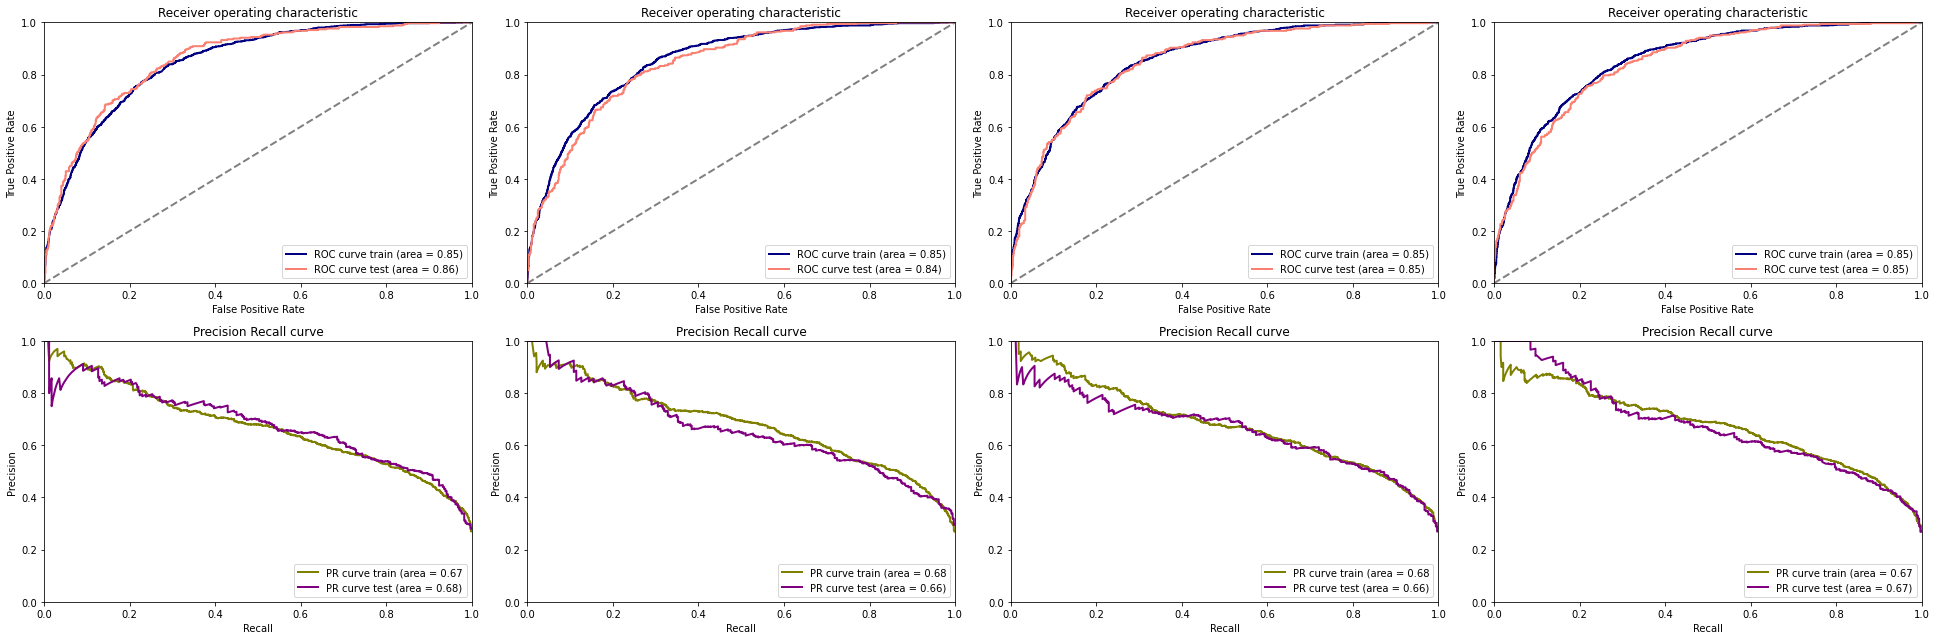

In [15]:
#show charts from cross-validation
show_cv_results(cv_models1, np.array(X_tr), np.array(y_tr), cv_folds)

## Run final model
Use full train to train, then show scores on test

In [16]:
est = LR(max_iter=500, penalty='l1', C=.5, solver='saga')
est.fit(X_tr, y_tr)

LogisticRegression(C=0.5, max_iter=500, penalty='l1', solver='saga')

### Show final scores
Do not update parameters of modelling according test scores (as it goes against good methodology - modifying things based one test data is form of manual overfitting), instead, if you need to update them, do that in cross-validation part

In [17]:
print('TRAIN SCORES:')
scores_tr = get_all_scores(est, X_tr, y_tr)
print(scores_tr)

print('TEST SCORES:')
#For test scores, we can use function get_all_scores only for ROC AUC, and PR AUC, as these are not dependent on threshold.
#But for threshold-dependent metrics, we must use threshold from train, as it's not valid methodology to determine the threshold on test set (i.e. we won't see new samples labeled in reality)
#As get_all_scores calculates best threshold, we must not use it for recall, precision, f1, and accuracy scores.
scores_ts = get_all_scores(est, X_ts, y_ts)
roc_ts, pr_ts = scores_ts['roc'], scores_ts['pr']

y_ts_pred_train_thr = np.array(est.predict_proba(X_ts)[:,1] > scores_tr['topf1_threshold']).astype(int) #binary predictions on test, based on threshold from train
print(f"test recall at train's top f1 threshold: {recall_score(y_ts, y_ts_pred_train_thr)}")
print(f"test precision at train's top f1 threshold: {precision_score(y_ts, y_ts_pred_train_thr)}")
print(f"test f1 at train's top f1 threshold: {f1_score(y_ts, y_ts_pred_train_thr)}")
print(f"test accuracy at train's top f1 threshold: {accuracy_score(y_ts, y_ts_pred_train_thr)}")

TRAIN SCORES:
{'roc': 0.8520590731974917, 'pr': 0.6749208440470582, 'recall_at_topf1': 0.7391623806024982, 'precision_at_topf1': 0.5654862282181, 'topf1': 0.640764331210191, 'topf1_threshold': 0.3286713883733751, 'accuracy_at_topf1': 0.780093494351383}
TEST SCORES:
test recall at train's top f1 threshold: 0.7657266811279827
test precision at train's top f1 threshold: 0.5621019108280255
test f1 at train's top f1 threshold: 0.6483011937557392
test accuracy at train's top f1 threshold: 0.7762850467289719


### Show coefficients and save result
Determine which variables are main drivers of churn

In [18]:
pd.Series(est.coef_[0],index=X_tr.columns).sort_values()

months_customer                              -1.274864
contract_type_Two year                       -0.734198
months_customer_binned_(71.0, 72.0]          -0.704053
has_multiple_lines_No                        -0.407291
electronic_billing_No                        -0.279142
is_senior_0                                  -0.223402
months_customer_binned_(24.0, 71.0]          -0.205909
payment_method_Mailed check                  -0.131282
has_phone_service_Yes                        -0.100922
has_dependents_Yes                           -0.097399
payment_method_Credit card (automatic)       -0.053777
has_partner_No                               -0.023991
uses_device_protection_No internet service   -0.018966
has_internet_No                              -0.018966
uses_tech_support_No internet service        -0.018966
uses_streaming_movies_No internet service    -0.018966
has_online_security_No internet service      -0.018966
uses_streaming_tv_No internet service        -0.018966
uses_onlin

In [19]:
#save probability of churn for each client and save
churn_probabilities = est.predict_proba(X_all_pd)[:,1]
df_output = df_shuffled.copy()
df_output['churn_proba'] = churn_probabilities
df_output['months_customer_binned'] = df_output['months_customer_binned'].astype(str)
df_output.to_csv('dataset_with_churn_proba.csv',index=False)

# Takeaway message
From the provided data, we can see, that churn is definitely driven by some specific variables:
 - People who joined as customers recently (up to 6 months ago) are most critical possible churners.
 - People who have Fiber optic internet connection are also possible churners
 - It is important to see, that longer contract types are better for company, although they is little lower monthly profit, it is still better to offer long-term contract, because probability of churn is lower, thus total profit from such customer may be higher in the end.
 - It is also good to remember, that customers who are not using tech support and don't have online security, are also more likely to churn
 - On the other hand, streaming movies and streaming tv usage is not desired, as customers with these two services are more likely to churn as well
 - Customers with one line are also less likely to churn
 
Conclusion: The most important is to keep customers when they are new. Very good way can be offering two (or at least one) year contract, not month-to-month contract. Be aware that having movie and TV services can also lead to higher churn possibilty, when customer has Fiber optic internet, it is also more dangerous. Finally, it is good to watch customers who don't have online security, or who does not use tech support, as their chance to churn is also higher.